# Lab: Create and Encode Time Series Features [SOLUTION]

## Overview

This lab extends the knowledge you gained in the tutorial notebook `tutorial-time-series-features.ipynb`. You will find additional practice for the topics covered in the tutorial and additional features to add to your toolkit when you work with time series data.

<div class="alert alert-success">
    Follow the <code>#TODO</code>s in the activities for this lab. For additional guidance on the activities and follow-up challenges, please refer to the <a href="../solutions/lab-create-encode-time-series-features-solution.ipynb" style="color: blue">solution notebook</a>.
</div>

### Learning objectives

By the end of this lab, you will be able to:
- Use trigonometric functions to encode date and time.
- Apply lags to multiple time series groups in a single dataset.
- Combine an expanding window with other operations to create a more complex feature.

### Estimated Time

This lab will take approximately **1 hour** to complete.

### Lab Setup

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

## Introduction

In this lab, you will work with smart bulb measurement data. These measurements are taken across the building you manage and you'd like to build a reliable model to predict when you will need to replace them. You are currently working with a truncated dataset to scope what kinds of features would be useful in a model. 

Run the following cell to load the dataset.

In [ ]:
df = pd.read_csv('../data/smartbulb_trunc.csv')
df['TS'] = pd.to_datetime(df['TS'])

## Activity 1: Shift multiple groups

This dataset contains bulb measurements from two different bulbs for a predictive maintennace use case. In this activity, you learn how to shift and mask the target variable for multiple groups, which may occur in the time series datasets you work with outside of this lab.

Let's examine the data. This dataset contains time series data for two smart bulbs—SMBLB4 and SMBLB7.

In [3]:
a1_df = df.copy()
a1_df.groupby('SN').first()

,TS,Status,Watts,Lumens,Temp,Voltage
SN,,,,,,
SMBLB4,2020-04-01,0,0.05,0.0,61.5,121
SMBLB7,2020-04-01,0,0.04,0.0,67.9,120


You may have noticed in this smart bulb measurement dataset that there is no target label. We will first compute when a bulb has failed.

We define that a bulb fails when the bulb does not emit light when it is turned on, so the failure condition is `Status==1 & Lumens==0.0`.

<div class="alert alert-info">
<b>Activity 1a</b><br>
Create a new column <code>failure</code> in <code>a2_df</code> based on the failure conditions specified.
</div>

In [ ]:
# # TODO: Create the labels based on the failure condition
# failures = np.where(...)

# a1_df['failure'] = failures

In [ ]:
# SOLUTION
# TODO: Create the labels based on the failure condition
# If the condition is met, return 1 for the record, otherwise 0.
failures = np.where((a1_df['Status']==1) & (a1_df['Lumens'] == 0), 1, 0)

a1_df['failure'] = failures

In [6]:
# Test your solution!
test_activity_1a(a1_df)

Passed!


For a predictive maintenance use case, it is a good idea to **mask** the failures, or hide them, so that the model doesn't rely on specific patterns in the data at the time of failure. We want to proactively predict when a bulb will fail, so we have time to repair it before it actually fails.

Rather than training a model on the actual failure indicators, we'll train it to detect if a bulb will fail in the near future. We will create a new column `willFailIn24Hours`, based on the `failure` column, which indicates whether or not the bulb will fail within the next day. 

We can use `shift` to create this feature, but there are two time series in this dataset so we can't simply use it on the entire `failure` column. Let's examine where the failures occur in our dataset.

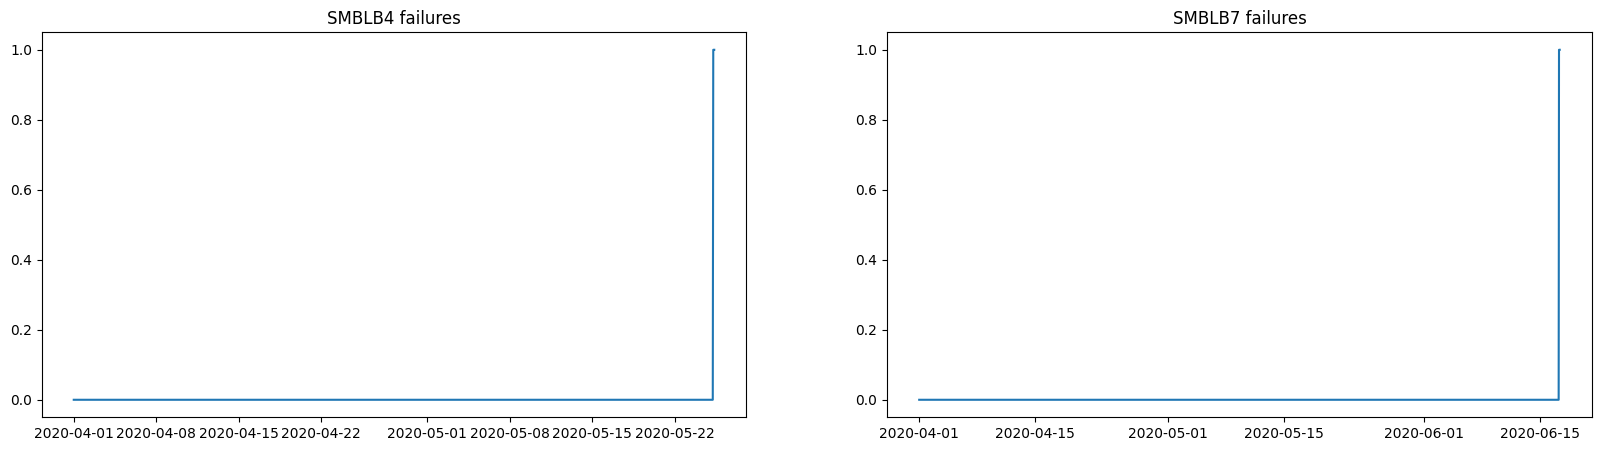

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
a = [ax2, ax1]
for i in a1_df['SN'].unique():
    sn_df = a1_df[a1_df['SN'] == i]
    a_ = a.pop()
    a_.plot(sn_df['TS'], sn_df['failure']);
    a_.set_title(f'{i} failures');

It seems like once the bulbs fail, the data stops recording. This means that the failures are the last measurements recorded for this dataset and we don't have to handle any data after the bulb is replaced. 

<div class="alert alert-info">
<b>Activity 1b</b><br>
Use <code>shift</code> to create a new column <code>willFailIn24Hours</code>, which indicates whether a bulb will fail within the next 24 hours. Add this column to <code>a1_df</code>. Your solution must follow these requirements:
<ul>
<li>Generate the shifted labels for both SMBLB4 and SMBLB7.</li>
<li>Replace the null values in your column with <code>ffill</code> (<a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ffill.html">ffill reference</a>). </li>
<li>After you create the column, drop the rows where <code>failure == 1</code> to mask the actual failure data.</li>
</ul>

Assign the resulting DataFrame to <code>a1_final</code>.
</div>

<div class="alert alert-warning">
<b>Hint:</b> One implementation is to use groupby to apply the transformation per group on a particular column.
</div>

In [ ]:
# # TODO: Create willFailIn24Hours for each SMBLB
# # Use as many lines as you need!
# shifted = ...

# a1_df['willFailIn24Hours'] = shifted

# # TODO: Mask the observed failures and assign the final table to `a2_final`
# a1_final = ...

In [ ]:
# SOLUTION
# TODO: Create willFailIn24Hours for each SMBLB
# Group by serial number, then shift the `failure` values per group back 24 rows.
# Forward fill the values so that we fill the NaNs with 1s.
shifted = a1_df.groupby('SN')['failure'].shift(-24).ffill()

a1_df['willFailIn24Hours'] = shifted

# TODO: Mask the observed failures and assign the final table to `a2_final`
a1_final = a1_df[a1_df['failure'] != 1]

In [10]:
# Test your solution!
test_activity_1b(a1_final)

[Case 1: Mask failures] Passed!
[Case 2: Lagged target] Passed!
[Case 3: Timestamps] Passed!


Run the following cell to plot your solution code. You should see the 24 hour shift in the failure label, with the original `failure` observations in red.

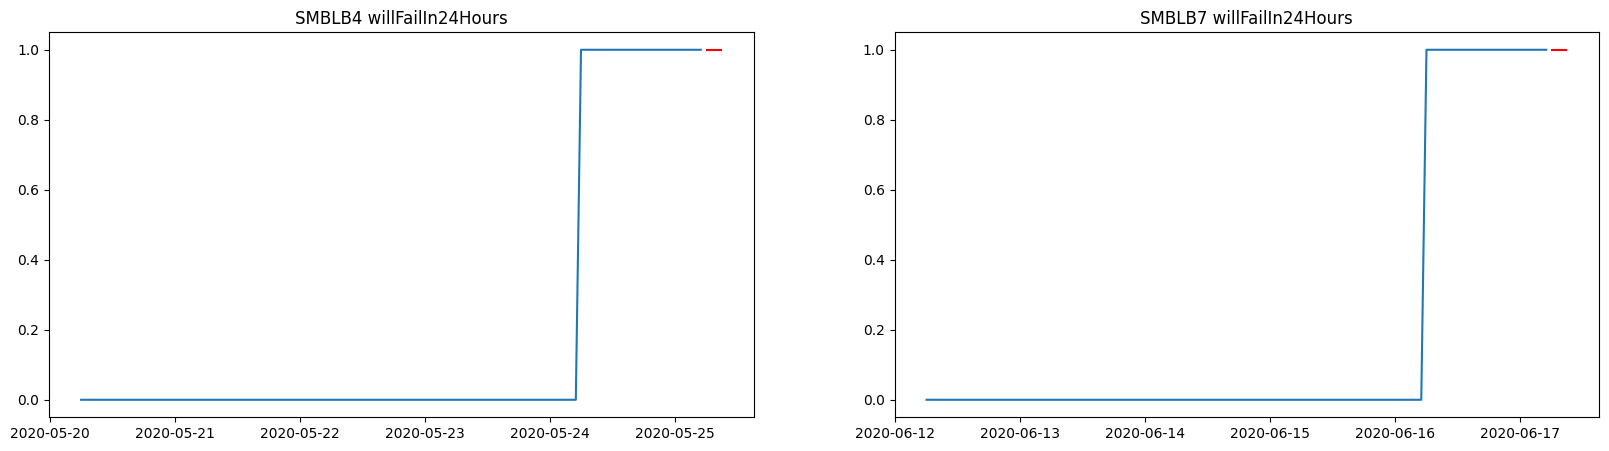

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
a = [ax2, ax1]
for i in a1_final['SN'].unique():
    sn_df = a1_final[a1_final['SN'] == i]
    
    idx = sn_df['willFailIn24Hours'].ne(0).idxmax()
    ts_ = sn_df.loc[idx, :]['TS'] - np.timedelta64(96, 'h')
    # only show last 5 days
    sn_df = sn_df[sn_df['TS'] >= ts_]
    a_ = a.pop()
    a_.plot(sn_df['TS'], sn_df['willFailIn24Hours']);
    
    failure_ts = a1_df[(a1_df['failure'] == 1) & (a1_df['SN'] == i)]['TS'].values[0]
    a_.hlines(y=1, xmin=failure_ts, xmax=failure_ts + np.timedelta64(3, 'h'), color='r');
    a_.set_title(f'{i} willFailIn24Hours');

<div class="alert alert-info">
<b>Follow-up challenge</b><br>
In the activity, creating the lag feature to mask the failure only requires shifting back 24 rows for each smart bulb.

Consider the situation in which there is data recorded after the bulb fails and is replaced. How would you go about creating the label for the dataset? 

For this challenge, create a new column <code>willFailIn24Hours</code> with the shifted values.
</div>

In [12]:
challenge = pd.read_csv('data/shift_challenge.csv', parse_dates=['TS'])

# OPTIONAL CHALLENGE
...

Ellipsis

In [ ]:
# SOLUTION
# Create the failure column
challenge['failure'] = np.where((challenge['Status']==1) & (challenge['Lumens'] == 0), 1, 0)

# Proceed similarly in the activity 1b
shifted = challenge.groupby('SN')['failure'].shift(-24).fillna(0)

# Take a rolling max over the shifted column to get `willFailIn24Hours`, 
# which will propagate the 1s over the next 24 hours.
challenge['willFailIn24Hours'] = shifted.rolling(window=24, min_periods=0).max().reset_index(drop=True)

# Verify the first timestamp of willFailIn24Hours==1 is 24 hours before the 
# first timestamp of failure==1.
challenge[challenge['willFailIn24Hours'] == 1]

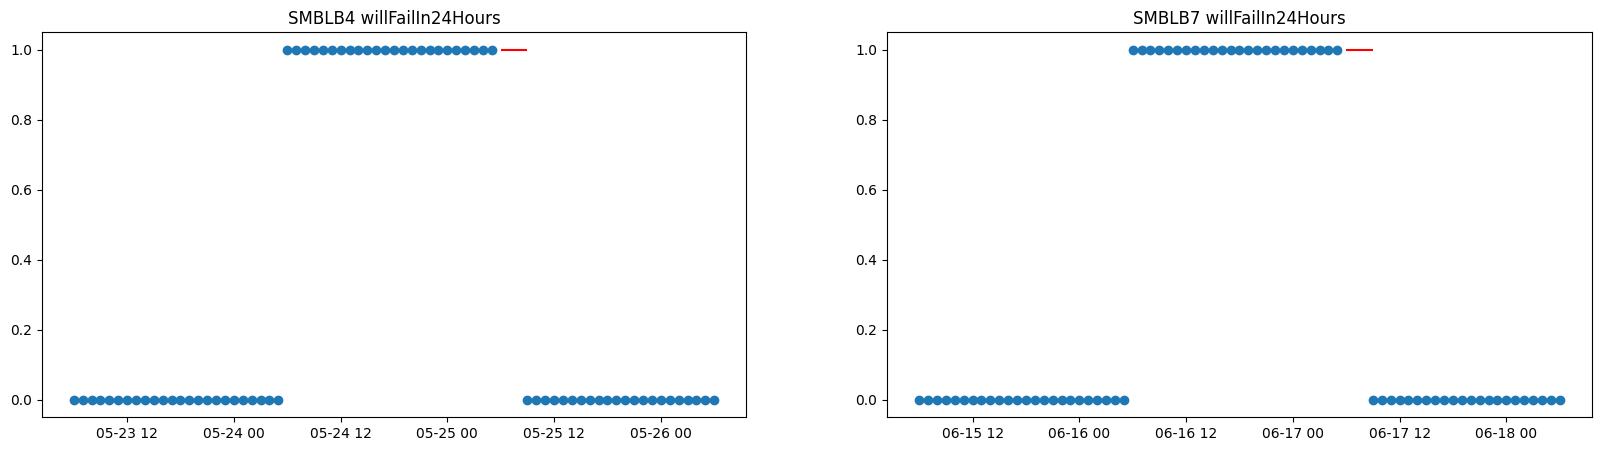

In [ ]:
# Plot the challenge results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
a = [ax2, ax1]
for i in challenge['SN'].unique():
    sn_df = challenge[(challenge['SN'] == i) & (challenge['failure'] != 1)]
    
    idx = sn_df['willFailIn24Hours'].ne(0).idxmax()
    ts_min = sn_df.loc[idx, :]['TS'] - np.timedelta64(24, 'h')
    ts_max = sn_df.loc[idx, :]['TS'] + np.timedelta64(48, 'h')
    # only show last 5 days
    sn_df = sn_df[(sn_df['TS'] >= ts_min) & (sn_df['TS'] <= ts_max)]
    a_ = a.pop()
    a_.scatter(sn_df['TS'], sn_df['willFailIn24Hours']);
    
    failure_ts = challenge[(challenge['failure'] == 1) & (challenge['SN'] == i)]['TS'].values[0]
    a_.hlines(y=1, xmin=failure_ts, xmax=failure_ts + np.timedelta64(3, 'h'), color='r');
    a_.set_title(f'{i} willFailIn24Hours');

## Activity 2: Switch count

Frequently switching light bulbs on and off may shorten its operating life. This could be a promising feature for your model! In this activity, you will use an expanding window with other operations to transform the `Status` column into the number of times a bulb was switched on and off.

Let's use one bulb for simplicity. Run the following cell, which will display the status of SMBLB4 across two days.

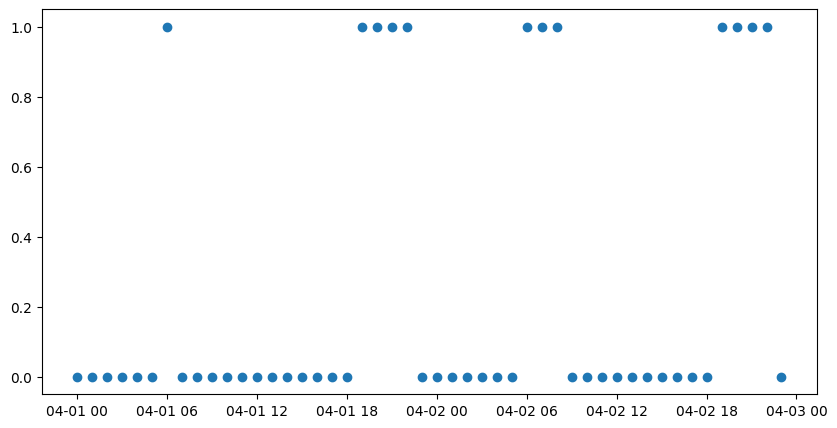

In [ ]:
a2_df = df.copy()
a2_df = a2_df[a2_df['SN']=='SMBLB4']

sample = a2_df[a2_df['TS'] < '2020-04-03']
plt.figure(figsize=(10, 5));
plt.scatter(sample['TS'], sample['Status']);

The `Status` column indicates if the bulb is on or off. We can use the change in status to calculate when the bulb is turned on or off. Hour by hour, we have three cases:

- The status stays the same, so no switch happened. 
- If a bulb has `status=0` and `status=1` the following hour, we know that the bulb was turned on. 
- If a bulb has `status=1` and then has `status=0`, then we know the bulb was turned off.

To calculate these changes in status, we compute the **difference** between each observation. Pandas provides the [diff](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.diff.html) API to find the differences between elements. 

<div class="alert alert-info">
<b>Activity 2a</b><br>
Use <code>diff</code> to compute the changes in status and assign it to a new column <code>switch</code>.
</div>

In [16]:
# # TODO: Create the `switch` column.
# a2_df['switch'] = ...

In [ ]:
# SOLUTION
# TODO: Create the `switch` column.
# Take the difference between the status and fill the null value (the first row) with 0.
# We take the absolute value because 1 -> 0 will return -1 and we want all values to be positive.
a2_df['switch'] = a2_df['Status'].diff().fillna(0).abs()

In [18]:
# Test your solution!
test_activity_2a(a2_df)

Passed!


To compute the total switch count, we use an expanding window and sum all status changes.


<div class="alert alert-info">
<b>Activity 2b</b><br>
Use an expanding window to sum all values.
</div>


In [19]:
# # TODO: Use an expanding window to calculate the `switch_count` column.
# a2_df['switch_count'] = ...

# # Visualize the new feature. It should gradually increase.
# plt.figure(figsize=(10, 5));
# plt.plot(a2_df['TS'], a2_df['switch_count']);

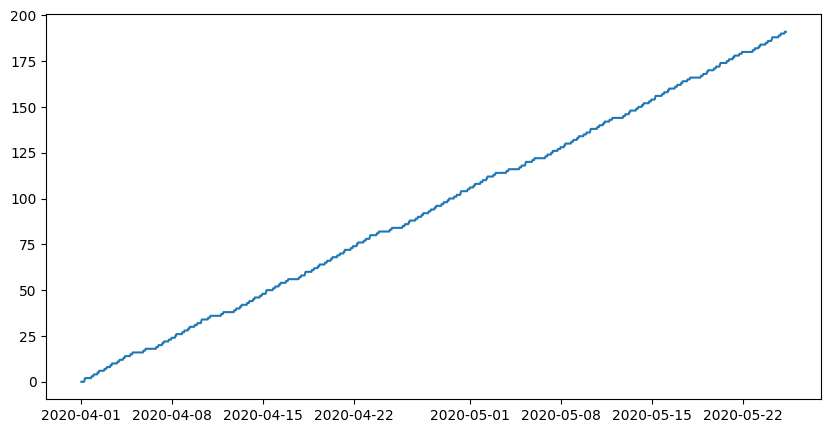

In [20]:
# SOLUTION
# TODO: Use an expanding window to calculate the `switch_count` column.
a2_df['switch_count'] = a2_df['switch'].expanding().sum()

# Visualize the new feature.
plt.figure(figsize=(10, 5));
plt.plot(a2_df['TS'], a2_df['switch_count']);

In [21]:
# Test your solution!
test_activity_2b(a2_df)

Passed!


<div class="alert alert-info">
<b>Follow-up challenge</b><br>
We calculated the switch count for only one bulb. How would you generalize this operation to the entire dataset (for all bulbs)?
</div>

In [ ]:
# # OPTIONAL CHALLENGE
# a2_challenge = df.copy()

# ...

In [ ]:
# SOLUTION
a2_challenge = df.copy()

# Apply the diff to `Status` for each group. 
a2_challenge['switch_all'] = a2_challenge.groupby('SN')['Status'].diff().fillna(0).abs().expanding().sum()

In [ ]:
# Run this to check your implementation
assert a2_challenge[a2_challenge['SN'] == 'SMBLB4']['switch_all'].equals(a2_df['switch_count'])

## Activity 3: Encode date and time with trigonometric functions

Recall from the tutorial, where we used numbers 0-6 (Monday through Sunday) to indicate the day of the week. In this activity, we'll demonstrate another way to encode date and time using trigonometric functions. 

Values that seem very far in absolute magnitude, like 23:00 (11:00PM) and 01:00 (1:00AM), are actually quite close. We can utilize trigonometric functions to represent months, days, hours, etc. given their cyclical nature.

Run the following cell to setup the data for this activity.

/var/folders/nt/4hgzk8fs49j_hfcvmgp896700000gn/T/ipykernel_24275/919671309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a3_df['hour'] = a3_df['TS'].apply(lambda x: x.hour);


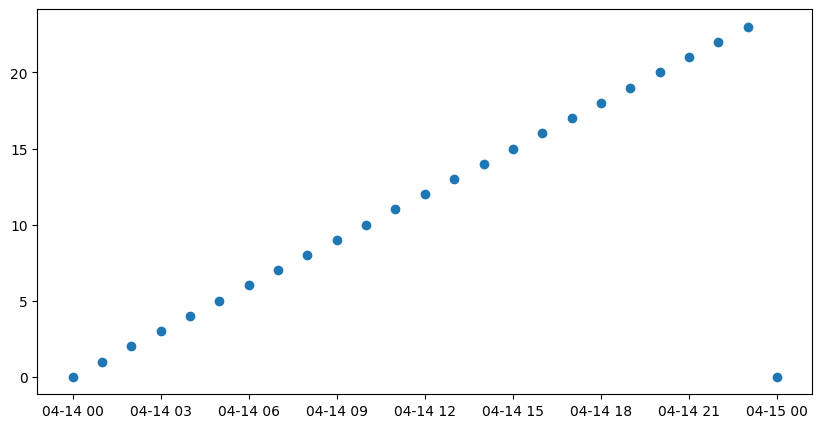

In [24]:
a3_df = df[df['SN']=='SMBLB4']

a3_df['hour'] = a3_df['TS'].apply(lambda x: x.hour);
a3_df = a3_df[(a3_df['TS'] >='2020-04-14') & (a3_df['TS'] <= '2020-04-15')]
plt.figure(figsize=(10, 5));
plt.scatter(a3_df['TS'], a3_df['hour']);

The plot above shows a similar pattern to the weekday plot in the tutorial. Using sine and cosine transformations can eliminate the break between hours 23 and 0 (or 11PM and 12AM).

Let's start by encoding each hour of the day to a point in the unit circle, starting with `sin`.

<div class="alert alert-info">
<b>Activity 3a</b><br>
Use <code>np.sin</code> to apply a sine transformation to the <code>hour</code> column. Assign the transformed values to a new column <code>hour_sin</code>.
</div>

<div class="alert alert-warning"> 
<b>Hint:</b> Use the number of hours in a day along with <code>2*pi</code>.
</div>

In [25]:
# # TODO: Create the `hour_sin` column.
# a3_df['hour_sin'] = a3_df['hour'].apply(lambda x: ...)

In [ ]:
# SOLUTION
# TODO: Create the `hour_sin` column.
# Split the unit circle by 24 (the length of the period).
a3_df['hour_sin'] = a3_df['hour'].apply(lambda x: np.sin(x / 24 * 2 * np.pi))

In [27]:
# Test your solution!
test_activity_3a(a3_df)

Passed!


You may also check your solution by using the following visualization. You should see that 3/14 00:00 (12:00AM) and 3/14 12:00 (12:00PM) have the same Y-values.

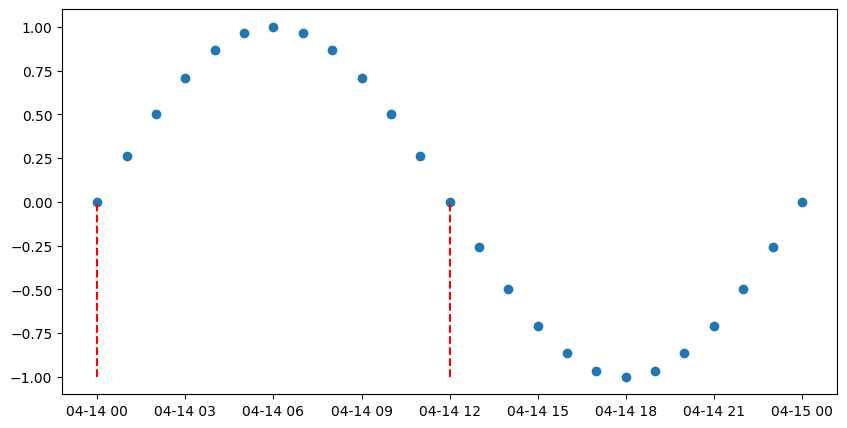

In [ ]:
plt.figure(figsize=(10, 5));
plt.scatter(a3_df['TS'], a3_df['hour_sin']);
plt.vlines(x=pd.to_datetime('2020-04-14 00:00:00'), ymin=-1, ymax=0, color='r', linestyles='dashed');
plt.vlines(x=pd.to_datetime('2020-04-14 12:00:00'), ymin=-1, ymax=0, color='r', linestyles='dashed');

This is a step in the right direction, but we'll need to include another transformation since different hours of the day (00:00 and 12:00) are taking on the same value.

If you guessed that we'll need to use cosine, you'd be correct! We'll have to use both sine and cosine to encode all 24 hours of the day.

<div class="alert alert-info">
<b>Activity 3b</b><br>
Use <code>np.cos</code> to apply a cosine transformation to the <code>hour</code> column. Assign the transformed values to a new column <code>hour_cos</code>.
</div>

In [29]:
# # TODO: Create the `hour_cos` column.
# a3_df['hour_cos'] = ...

In [30]:
# SOLUTION
# TODO: Create the `hour_cos` column.
a3_df['hour_cos'] = a3_df['hour'].apply(lambda x: np.cos(x / 24 * 2 * np.pi))

In [31]:
# Test your solution!
test_activity_3b(a3_df)

Passed!


If you run the following cell now, you should see that the addition of the cosine transformation is sufficient to encode the hours of the day and we can identify the hour of the day based on these two new features.

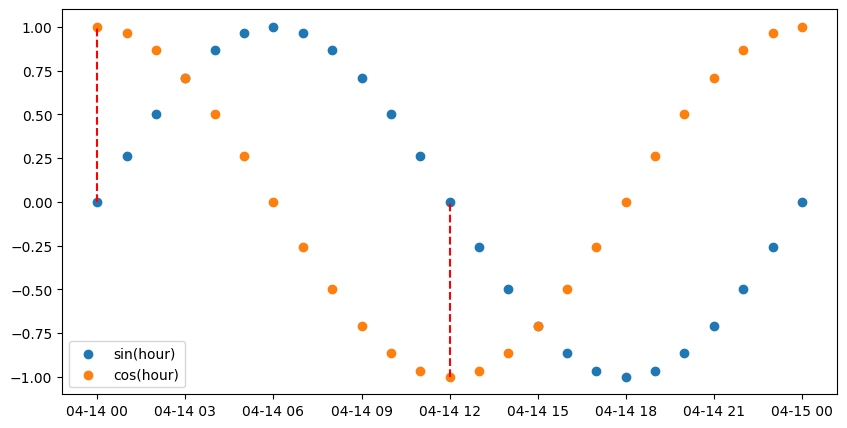

In [32]:
plt.figure(figsize=(10, 5));
plt.scatter(a3_df['TS'], a3_df['hour_sin'], label='sin(hour)');
plt.scatter(a3_df['TS'], a3_df['hour_cos'], label='cos(hour)');
plt.vlines(x=pd.to_datetime('2020-04-14 00:00:00'), ymin=0, ymax=1, color='r', linestyles='dashed');
plt.vlines(x=pd.to_datetime('2020-04-14 12:00:00'), ymin=-1, ymax=0, color='r', linestyles='dashed');
plt.legend();

We can map the values onto a circle for an alternate view of the transformations we performed. We've effectively created a 24-hour clock!

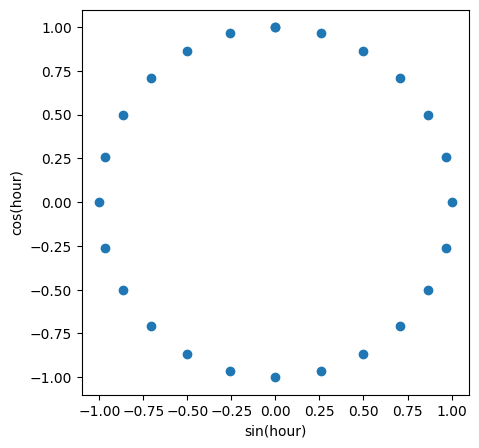

In [33]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(a3_df["hour_sin"], a3_df["hour_cos"]);
ax.set(xlabel="sin(hour)", ylabel="cos(hour)");

-----

🎉 Congratulations! You finished the lab on creating and encoding time series features. 